<a href="https://colab.research.google.com/github/RyanChen12035/w266_final_Anatomy-and-Structured-Prunning/blob/main/Llama2_ft_Qlora_boolq_TSMC_IT_BSID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets accelerate peft bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 29.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.wh

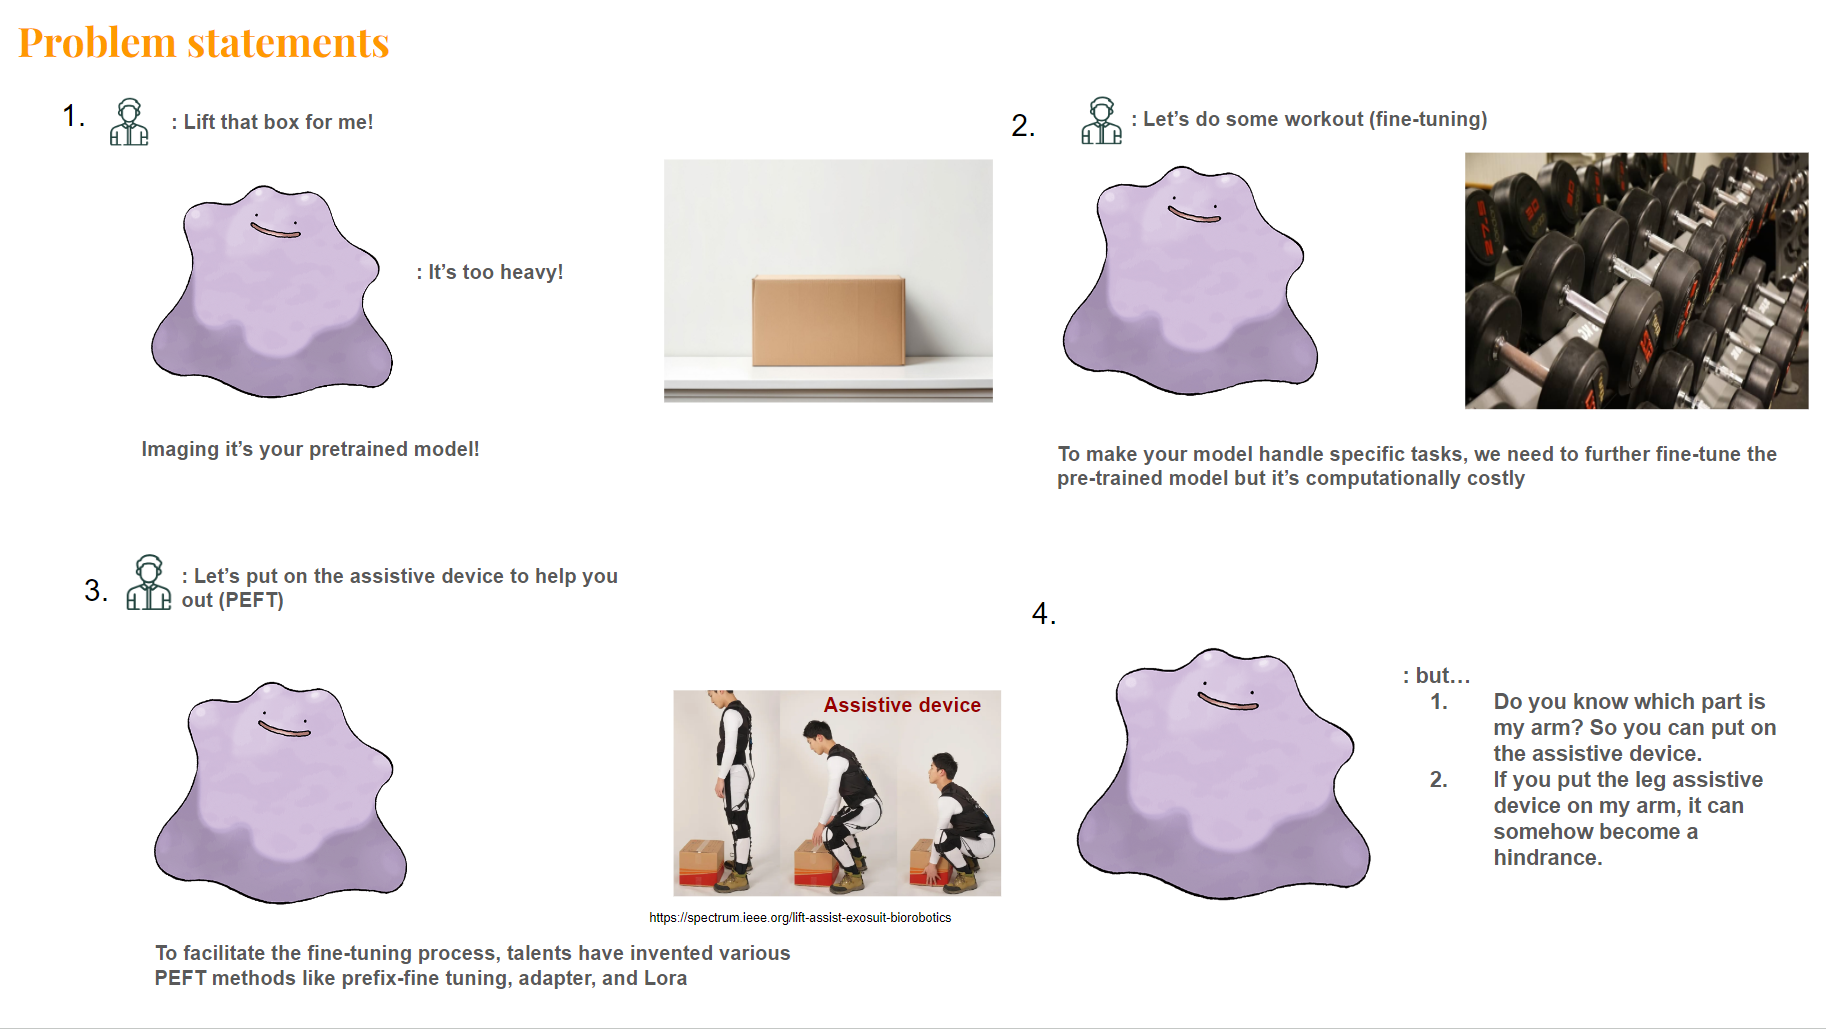

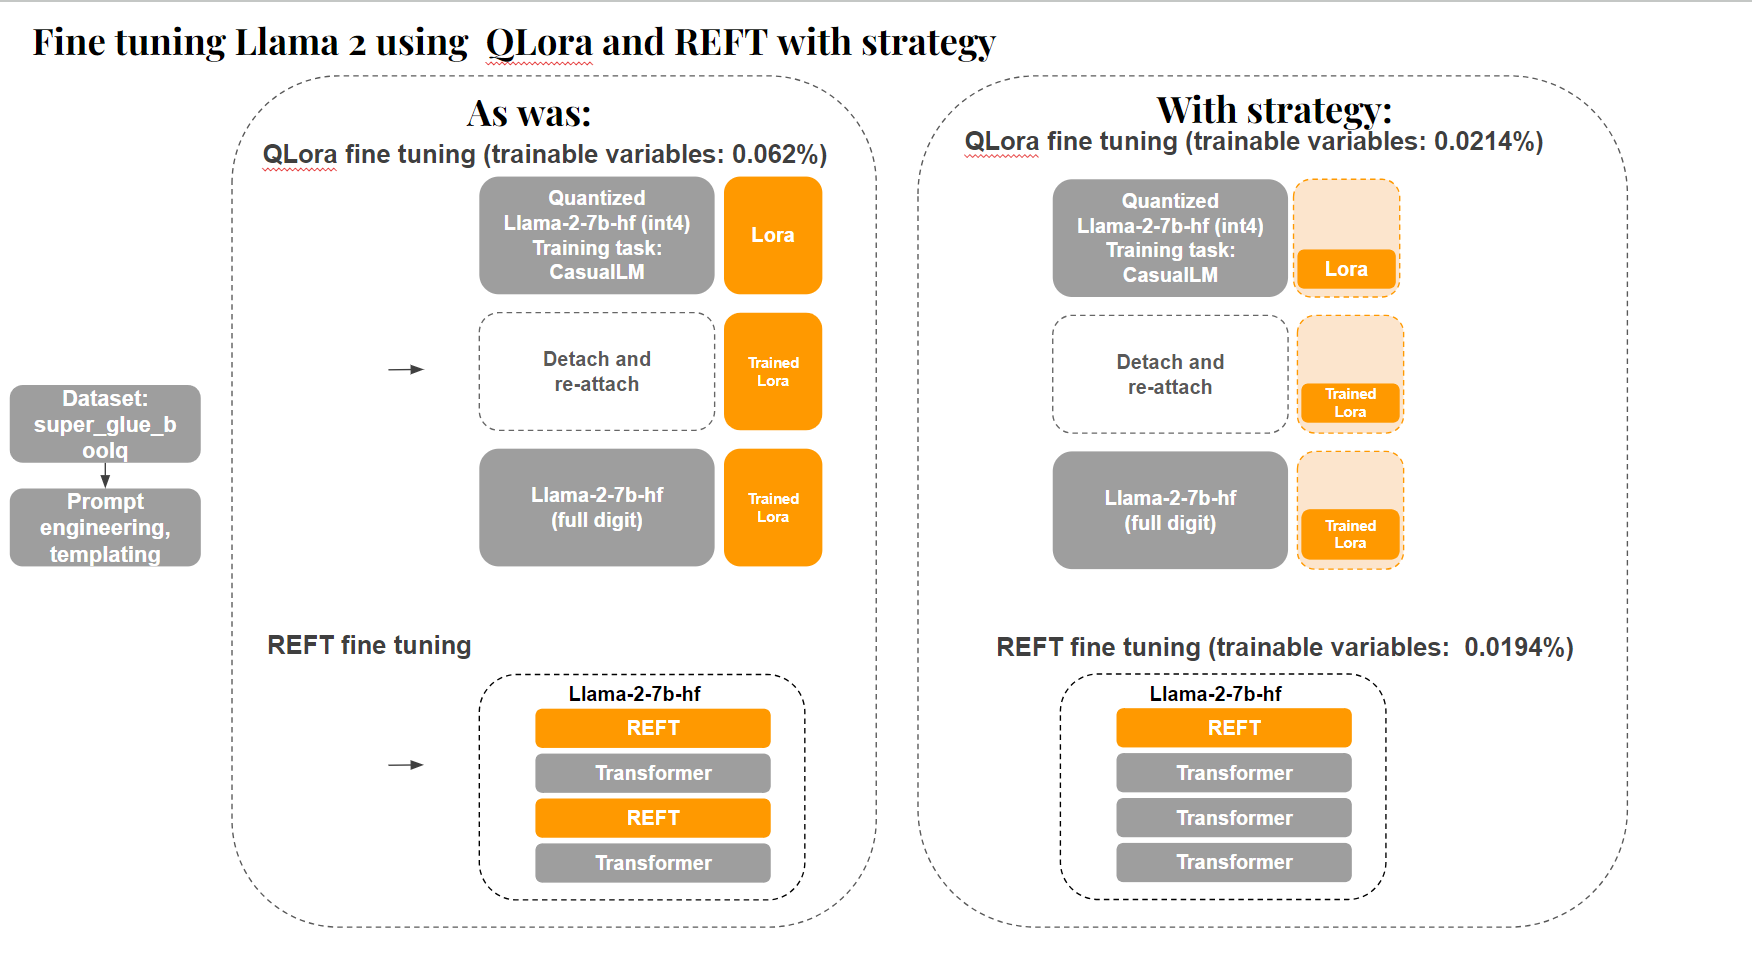

For SFT and RLHF
1. When we are doing fine-tuning, we are asking our model to memorize the answer while understanding the logic, format and style of answer we need.
2. When we are doing PEFT fine-tuning, since we only haave a pinch of the trainable variable, the model would focus on logic, format and style.
3. When we are doing RLHF, the model would have a tendancy of learning format and style depends on the human feedback and design of penalty function.
4. RAG can help with memory intensive task.

So which type of training do we need is heavily according to what type of task we are going to ask our model to do.

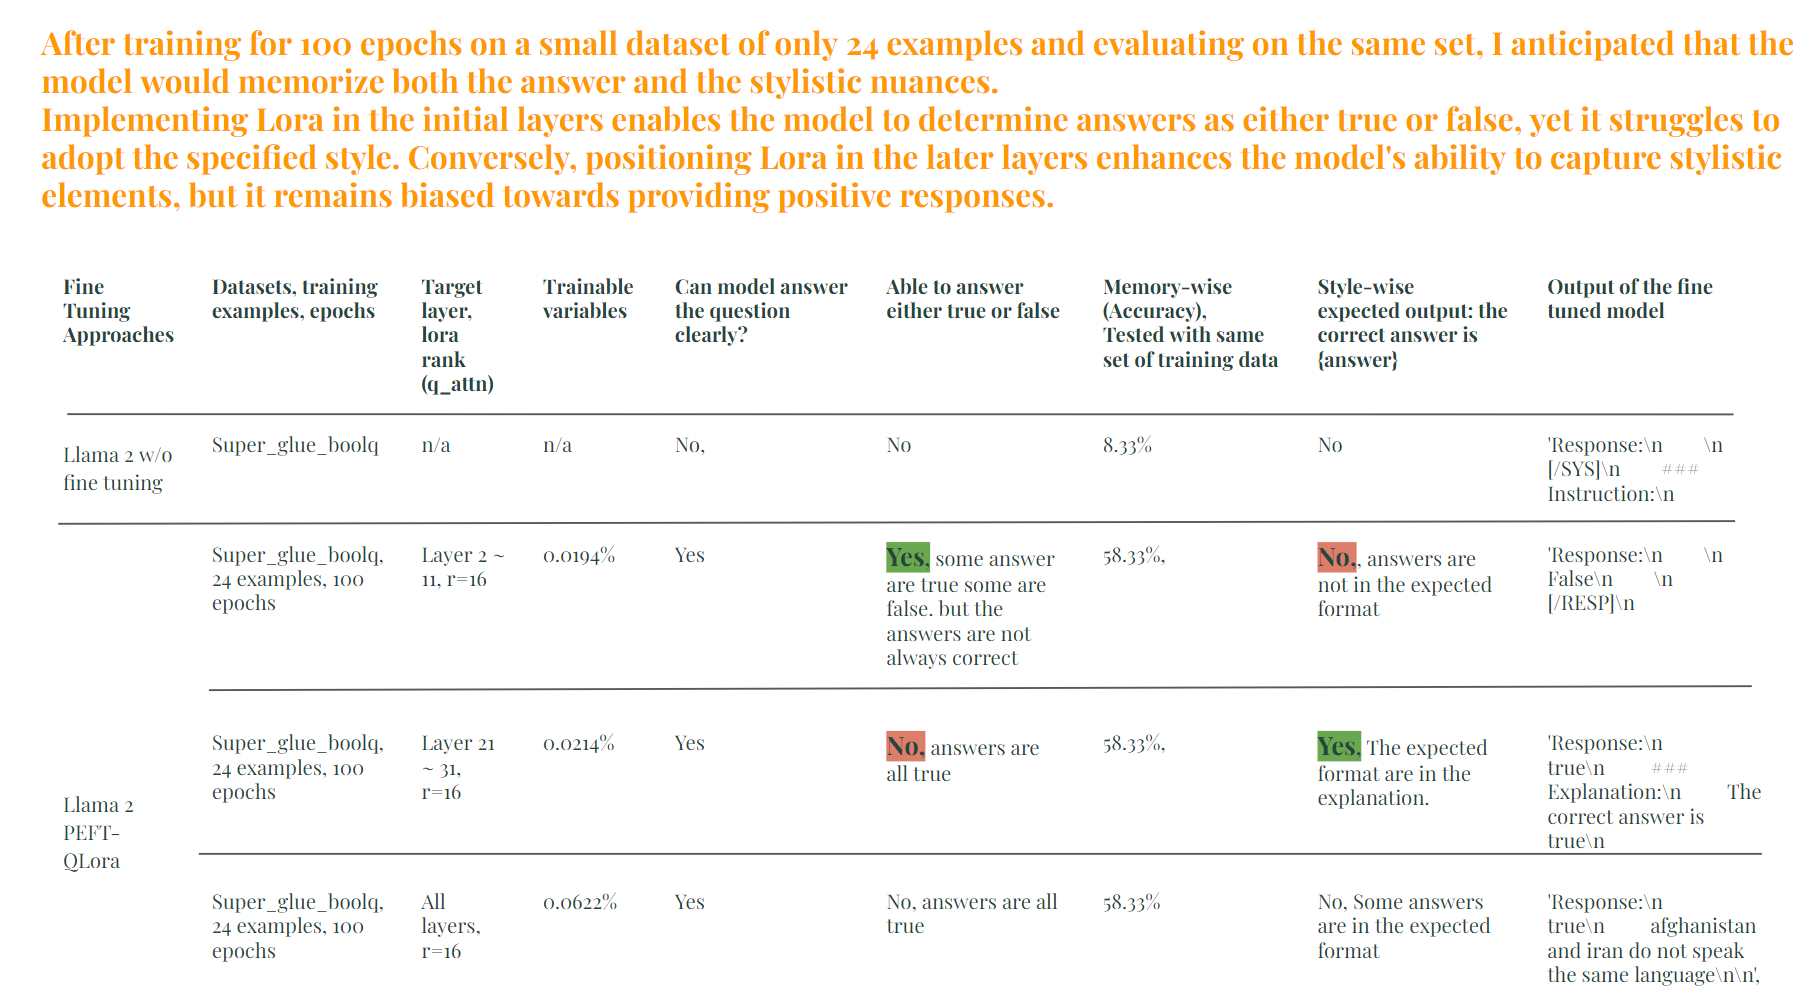

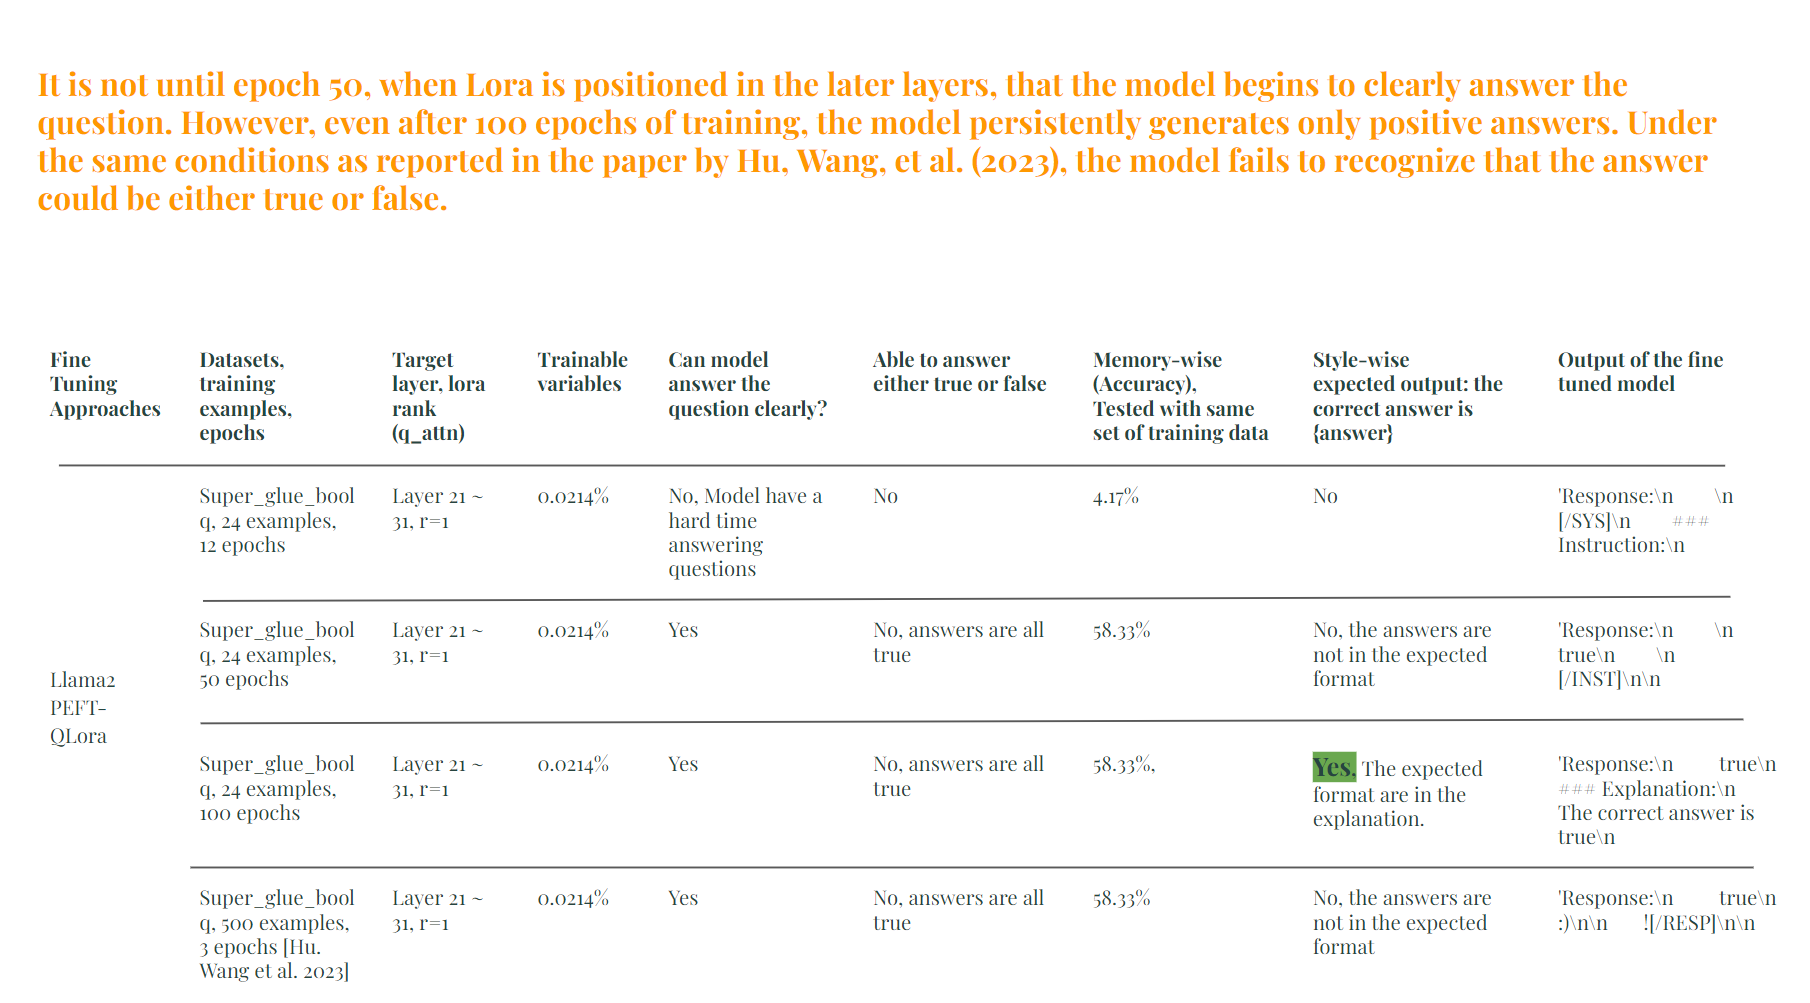

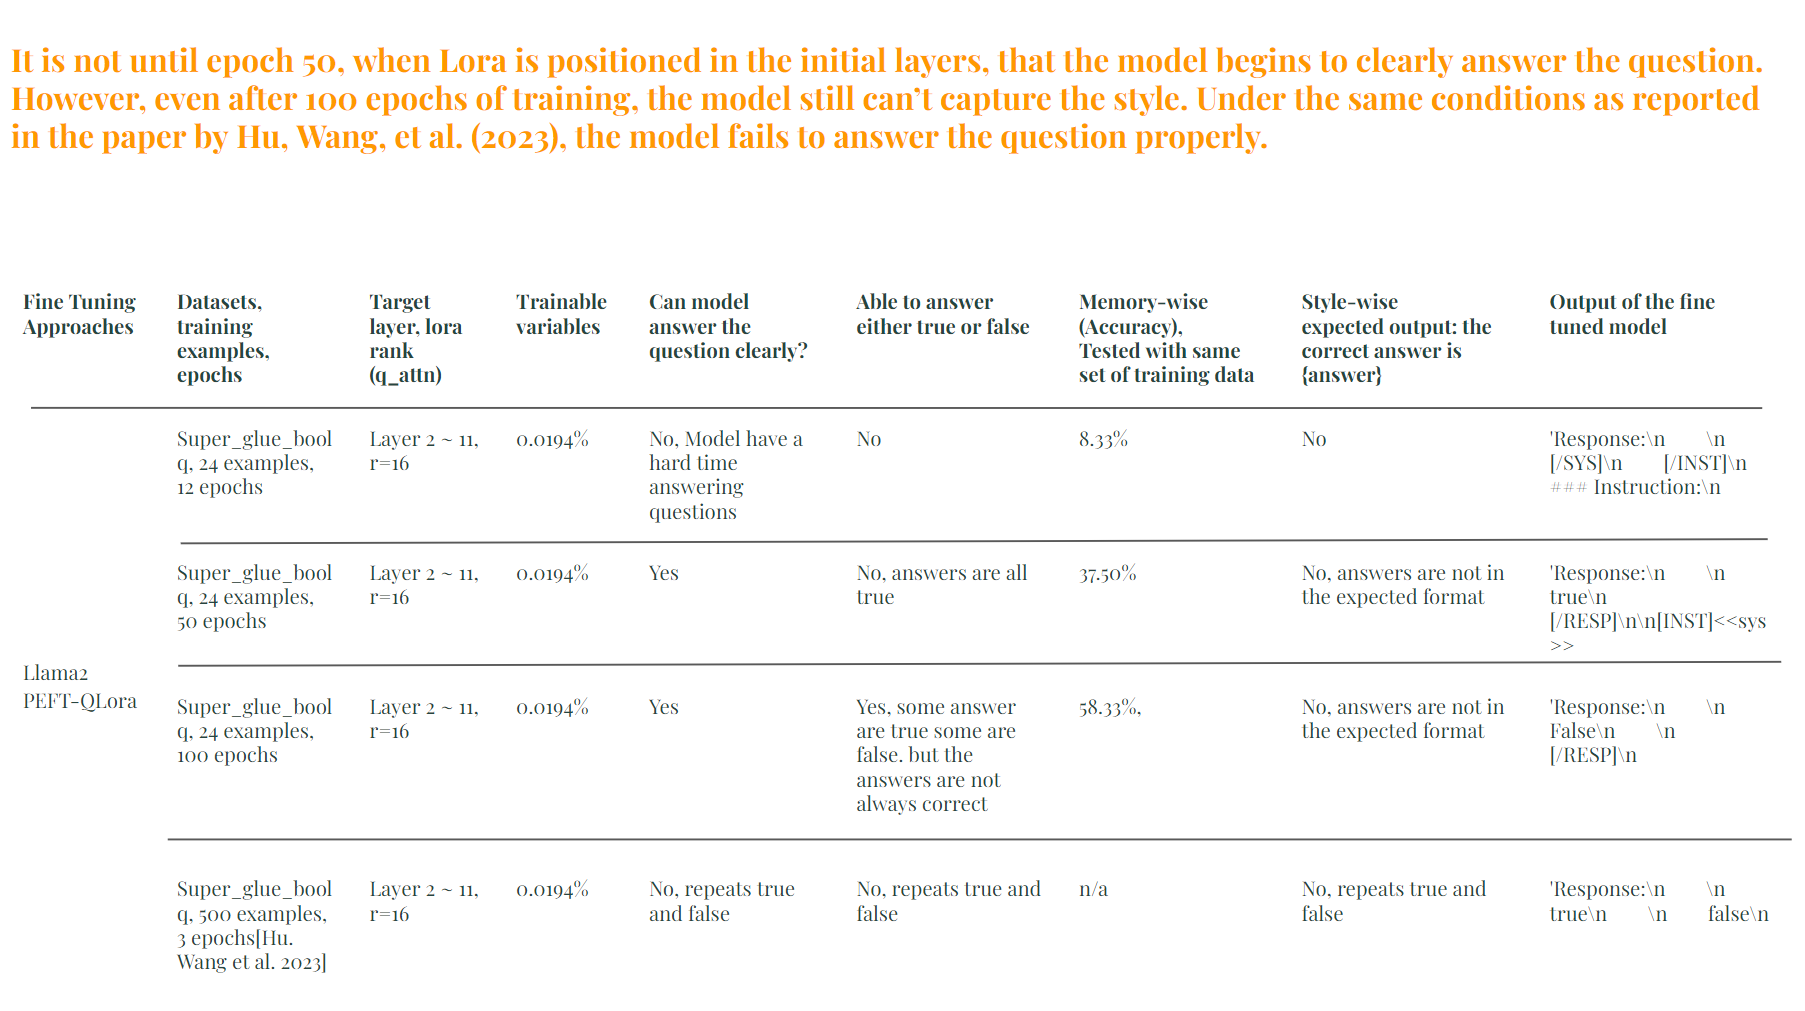

In [ ]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    AutoTokenizer,
    TrainingArguments,
    pipeline,
    Trainer,
    DataCollatorForLanguageModeling
)
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training, get_peft_model

In [ ]:
dataset_name = 'super_glue'
config = 'boolq'
dataset = load_dataset(dataset_name, config)
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['question', 'passage', 'idx', 'label'],
        num_rows: 9427
    })
    validation: Dataset({
        features: ['question', 'passage', 'idx', 'label'],
        num_rows: 3270
    })
    test: Dataset({
        features: ['question', 'passage', 'idx', 'label'],
        num_rows: 3245
    })
})

In [ ]:
def template_prompt_engineering(example):
  # add system template of Llama2 and prompt engineering for the boolq task
  example['label'] = "the correct answer is true" if example['label'] else "the correct answer is false"
  example['question'] = f"""Please answer the following queation with true or false, question: {example['question']}?\n\nAnswer format: true/false"""
  example['text'] = f"""<s>[INST]<<sys>>Below is an instruction that describes a task. Write a response that appropriately completes the request<</sys>>
        ### Instruction:
        {example['question']}[/INST]

        ### Response:
        {example['label']}
        """
  return example

dataset_withtemplate = dataset.map(template_prompt_engineering, remove_columns=['question', 'passage', 'idx', 'label'])
dataset_withtemplate['train'].to_pandas()

# it's a CLM (autoregressive task), the model would take the output of tokenizer as input and input shifting one position as label
# we only need an input

,text
0,<s>[INST]<<sys>>Below is an instruction that d...
1,<s>[INST]<<sys>>Below is an instruction that d...
2,<s>[INST]<<sys>>Below is an instruction that d...
3,<s>[INST]<<sys>>Below is an instruction that d...
4,<s>[INST]<<sys>>Below is an instruction that d...
...,...
9422,<s>[INST]<<sys>>Below is an instruction that d...
9423,<s>[INST]<<sys>>Below is an instruction that d...
9424,<s>[INST]<<sys>>Below is an instruction that d...
9425,<s>[INST]<<sys>>Below is an instruction that d...


In [ ]:
# it's a CLM (autoregressive task), the model would take the output of tokenizer as input and input shifting one position as label
# tokenize the dataset, the trainer would take the key world input_ids and attention mask generated by the tokenizer
# Model
base_model = "NousResearch/Llama-2-7b-hf"
new_model = "llama-2-7b-Qlora-boolq-test"

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model, use_fast=True)
tokenizer.pad_token = tokenizer.unk_token
tokenizer.padding_side = "right"


def tokenize_function(examples):
    text = examples["text"]
    tokenized_inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    )
    return tokenized_inputs

tokenized_data = dataset_withtemplate.map(tokenize_function, batched=True)

# data collator for how to padding and truncating
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

tokenized_data['train'].to_pandas()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/3245 [00:00<?, ? examples/s]

,text,input_ids,attention_mask
0,<s>[INST]<<sys>>Below is an instruction that d...,"[1, 1, 29961, 25580, 29962, 9314, 9675, 6778, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,<s>[INST]<<sys>>Below is an instruction that d...,"[1, 1, 29961, 25580, 29962, 9314, 9675, 6778, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,<s>[INST]<<sys>>Below is an instruction that d...,"[1, 1, 29961, 25580, 29962, 9314, 9675, 6778, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,<s>[INST]<<sys>>Below is an instruction that d...,"[1, 1, 29961, 25580, 29962, 9314, 9675, 6778, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,<s>[INST]<<sys>>Below is an instruction that d...,"[1, 1, 29961, 25580, 29962, 9314, 9675, 6778, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...
9422,<s>[INST]<<sys>>Below is an instruction that d...,"[1, 1, 29961, 25580, 29962, 9314, 9675, 6778, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
9423,<s>[INST]<<sys>>Below is an instruction that d...,"[1, 1, 29961, 25580, 29962, 9314, 9675, 6778, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
9424,<s>[INST]<<sys>>Below is an instruction that d...,"[1, 1, 29961, 25580, 29962, 9314, 9675, 6778, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
9425,<s>[INST]<<sys>>Below is an instruction that d...,"[1, 1, 29961, 25580, 29962, 9314, 9675, 6778, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [ ]:
tokenized_data["validation"].to_pandas()

,text,input_ids,attention_mask
0,<s>[INST]<<sys>>Below is an instruction that d...,"[1, 1, 29961, 25580, 29962, 9314, 9675, 6778, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,<s>[INST]<<sys>>Below is an instruction that d...,"[1, 1, 29961, 25580, 29962, 9314, 9675, 6778, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,<s>[INST]<<sys>>Below is an instruction that d...,"[1, 1, 29961, 25580, 29962, 9314, 9675, 6778, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,<s>[INST]<<sys>>Below is an instruction that d...,"[1, 1, 29961, 25580, 29962, 9314, 9675, 6778, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,<s>[INST]<<sys>>Below is an instruction that d...,"[1, 1, 29961, 25580, 29962, 9314, 9675, 6778, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...
3265,<s>[INST]<<sys>>Below is an instruction that d...,"[1, 1, 29961, 25580, 29962, 9314, 9675, 6778, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3266,<s>[INST]<<sys>>Below is an instruction that d...,"[1, 1, 29961, 25580, 29962, 9314, 9675, 6778, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3267,<s>[INST]<<sys>>Below is an instruction that d...,"[1, 1, 29961, 25580, 29962, 9314, 9675, 6778, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3268,<s>[INST]<<sys>>Below is an instruction that d...,"[1, 1, 29961, 25580, 29962, 9314, 9675, 6778, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [ ]:
# base_model = "NousResearch/Llama-2-7b-hf"

# Quantization configuration
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
) # project the model weights to 4bits, pass torch fp16


# Load base moodel
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=bnb_config,
    device_map={"": 0}
) # download the CLM (autoregressive) model, calculate the loss function of next token.

#checkpointing to reduce the payload
model.gradient_checkpointing_enable()
# Cast the layernorm in fp32, make output embedding layer require grads, add the upcasting of the lmhead to fp32
model = prepare_model_for_kbit_training(model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuratio

In [ ]:
# LoRA configuration
peft_config = LoraConfig(
    r=16, # by analysis
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    layers_to_transform = [i for i in range(2, 12)], # layers from 6 to 11. by analysis
    target_modules=['q_proj'] # query attention
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

# all layers q_proj, trainable params: 4,194,304 || all params: 6,742,609,920 || trainable%: 0.0622
# 21~31 layers q_proj, trainable params: 4,194,304 || all params: 6,742,609,920 || trainable%: 0.0214
# 2~12 layers q_proj, trainable params: 655,360 || all params: 6,739,070,976 || trainable%: 0.0097 r = 8
# 2~12 layers q_proj, trainable params: 655,360 || all params: 6,739,070,976 || trainable%: 0.0194 r = 16
# all attention + MLP trainable params: 13,742,080 || all params: 6,752,157,696 || trainable%: 0.2035

trainable params: 1,310,720 || all params: 6,739,726,336 || trainable%: 0.0194


In [ ]:
# hyperparameters
lr = 2e-4
batch_size = 4
num_epochs = 100

# define training arguments
training_args = TrainingArguments(
    output_dir= "llama2-ft-qlora-boolq",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    logging_strategy="epoch", #update loss for each epochs
    evaluation_strategy="epoch", #update loss for each epochs
    save_strategy="epoch", #update loss for each epochs
    load_best_model_at_end=True,
    gradient_accumulation_steps=4,
    warmup_steps=2,
    fp16=True,
    optim="paged_adamw_8bit", #balance the memory usage between CPU and GPU
)


# configure trainer
trainer = Trainer(
    model=model,
    train_dataset=tokenized_data["train"].select(range(24)),
    eval_dataset=tokenized_data["validation"].select(range(4)),
    args=training_args,
    data_collator=data_collator
)

# train model
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

# renable warnings
model.config.use_cache = True

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Epoch,Training Loss,Validation Loss
0,5.541400,3.743811
2,5.500000,3.704283
4,5.378200,3.617852
6,5.215800,3.514914
8,5.050600,3.405787
10,4.851400,3.273723
12,4.666400,3.155062
14,4.483500,3.032902
16,4.298300,2.911907
18,4.114500,2.789039


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=T

In [ ]:
# Save trained model to variable new_model
trainer.model.save_pretrained(new_model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
# Empty VRAM
del model
# del pipe
del trainer
import gc
gc.collect()
gc.collect()

15247

In [ ]:
# reattach the lora on full digit model
# Reload model in FP16 and merge it with LoRA weights
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map={"": 0},
)
model = PeftModel.from_pretrained(model, new_model)
model = model.merge_and_unload()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuratio

In [ ]:
# inference
def template_prompt_engineering(example: str):
  # add system template of Llama2 and prompt engineering for the boolq task
  example = f"""<s>[INST]<<sys>>Below is an instruction that describes a task. Write a response that appropriately completes the request<</sys>>
        ### Instruction:
        Please answer the following queation with true' or false, question:{example}?\n\nAnswer format: true/false

        [/INST]
        ### Response:
        """
  return example

# Run text generation pipeline with our model
prompt = "does ethanol take more energy make that produces?"
templated_prompt = template_prompt_engineering(prompt)
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=128)
result = pipe(templated_prompt)
result_text = result[0]['generated_text']
print(result_text[result_text.find('Response'):result_text.find('Response')+100])

Response:
        
        [/SYS]
        ### Instruction:
        Please answer the following queat


In [ ]:
result

[{'generated_text': "<s>[INST]<<sys>>Below is an instruction that describes a task. Write a response that appropriately completes the request<</sys>>\n        ### Instruction:\n        Please answer the following queation with true' or false, question:does ethanol take more energy make that produces??\n\nAnswer format: true/false\n\n        [/INST]\n        ### Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queation with true' or false, question:does ethanol take more energy make that produces??\n\n"}]

# boolq evaluation

In [ ]:
dataset['validation'].to_pandas()

,question,passage,idx,label
0,does ethanol take more energy make that produces,Ethanol fuel -- All biomass goes through at le...,0,0
1,is house tax and property tax are same,Property tax -- Property tax or 'house tax' is...,1,1
2,is pain experienced in a missing body part or ...,Phantom pain -- Phantom pain sensations are de...,2,1
3,is harry potter and the escape from gringotts ...,Harry Potter and the Escape from Gringotts -- ...,3,1
4,is there a difference between hydroxyzine hcl ...,Hydroxyzine -- Hydroxyzine preparations requir...,4,1
...,...,...,...,...
3265,is manic depression the same as bi polar,"Bipolar disorder -- Bipolar disorder, previous...",3265,1
3266,was whiskey galore based on a true story,SS Politician -- SS Politician was an 8000-ton...,3266,1
3267,are there plants on the international space st...,Plants in space -- Plant research continued on...,3267,1
3268,does the hockey puck have to cross the line to...,"Goal (ice hockey) -- In ice hockey, a goal is ...",3268,1


In [ ]:
# inference
from tqdm.auto import tqdm
import numpy as np


def template_prompt_engineering(example: str):
  # add system template of Llama2 and prompt engineering for the boolq task
  example = f"""<s>[INST]<<sys>>Below is an instruction that describes a task. Write a response that appropriately completes the request<</sys>>
        ### Instruction:
        Please answer the following queation with the words 'true' or 'false', question:{example}?\n\nAnswer format: true/false
        [/INST]
        ### Response:
        """
  return example

predictions = []
for prompt in tqdm(dataset['train']['question'][:24]):
    templated_prompt = template_prompt_engineering(prompt)
    pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=128)
    result = pipe(templated_prompt)
    result_text = result[0]['generated_text']
    # print(result_text[result_text.find('Response'):result_text.find('Response')+100])
    predictions.append(result_text[result_text.find('Response'):result_text.find('Response')+100])


def extract_boolean_label(text):
    text = text.lower()
    if 'true' in text:
        return 1
    elif 'false' in text:
        return 0
    else:
        return None

binary_predictions = []
for pred in predictions:
    binary_predictions.append(extract_boolean_label(pred))

y = dataset['train']["label"][:24]

# Calculate accuracy
accuracy = np.mean(np.array(y) == np.array(binary_predictions))
print(f'Accuracy: {accuracy * 100:.2f}%')

  0%|          | 0/24 [00:00<?, ?it/s]

Accuracy: 58.33%


In [ ]:
predictions

#--high epochs: 100 / small dataset 24, expecting to memorize the answer and style
# 1 Qlora finetune with high-sensitive layers 21~31, r = 16: accuracy: 58.33% (24 examples with batch size 8) trainable%: 0.0214
# 2 Qlora finetune with all layers, r=16, accuracy: 58.33% trainable% 0.0622%
# 3 Qlora finetune with layers 12~21, r=16, accuracy: 58.33%% trainable%: 0.0194



#1
# even with 100 epochs, the model still can't figure out there are true and false, but the format of the explanation is correct!
#
# ['Response:\n         true\n         ### Explanation:\n         The correct answer is true\n         ### R',
#  'Response:\n         true\n         ### Explanation:\n         The correct answer is true\n         ### R',
#  'Response:\n         true\n         ### Explanation:\n         The correct answer is true\n         ### H',
#  'Response:\n         true\n         ### Explanation:\n         The correct response is true\n         ###',
#  'Response:\n         the correct answer is true\n         --happy\n         --happy\n         --happy\n   ',
#  'Response:\n         true\n         ### Expected:\n         true\n\n        ### Instruction:\n        Pleas',
#  'Response:\n         true\n         ### Explanation:\n         The correct response is true\n         ###',
#  'Response:\n         the federal court is the same as the supreme court\n         answer format: true/f',
#  'Response:\n         true\n         ### Explanation:\n         The correct answer is true\n         ### C',
#  'Response:\n         true\n         ### Explanation:\n         The correct response is true\n         ###',
#  'Response:\n         true\n         ### Explanation:\n         The above response is correct.\n\nAnswer fo',
#  'Response:\n         true\n         ### Explanation:\n         The correct response is true\n         ###',
#  'Response:\n         the correct answer is true\n         --hieu.le\n\nAnswer format: true/false',
#  'Response:\n         true\n         ### Explanation:\n         calcium carbide cac2 is the raw material ',
#  'Response:\n         true\n         ### Expected:\n         true\n\n        ### Instruction:\n        Pleas',
#  'Response:\n         true\n         ### Explanation:\n         The correct answer is true\n         ### R',
#  'Response:\n         true\n         ### Expected:\n         true\n\nAnswer format: true/false\n        [/IN',
#  'Response:\n         true\n         ### Explanation:\n         The correct response is true.\n         ##',
#  'Response:\n         true\n         ### Explanation:\n         The correct answer is true\n         ### R',
#  'Response:\n         the boy in the plastic bubble based on true story?\n         true\n         --mynam',
#  'Response:\n         true\n         ### Explanation:\n         The correct answer is true\n         ### R',
#  'Response:\n         true\n         ### Explanation:\n         The correct response is true\n         ###',
#  'Response:\n         true\n         ### Expected:\n         true\n\n        ### Instruction:\n        Pleas',
#  'Response:\n         true\n         ### Explanation:\n         The correct answer is true\n         ### H']


#2
# ['Response:\n         true\n         afghanistan and iran do not speak the same language\n\n',
#  'Response:\n         true\n        \n        ^^\n\n    Note: the instruction above is incorrect.\n\n    Code',
#  'Response:\n         true\n        ^^\n\n        correct answer:\n        true\n\n\n',
#  'Response:\n         true\n         true\n         true\n         true\n         true\n         true\n      ',
#  'Response:\n         correct answer is true\n       ! Response not accepted: the correct answer is fals',
#  'Response:\n         true\n        ^^\n\n        correct answer:\n        true\n\n\n       \n\n       \n\n       ',
#  'Response:\n         true\n\n        ^^\n\n    This response was created with a YAML template. To fill it ',
#  'Response:\n         true\n         true\n         true\n         true\n         true\n         true\n      ',
#  'Response:\n         true\n         happy new year\n\n',
#  'Response:\n         correct answer is true\n\n        ^^\n\n        This reply was generated by a templat',
#  'Response:\n         correct answer is: true\n\n        ^^\n\n        This reply was generated by a templa',
#  'Response:\n         true\n\n        ^^\n\n    Exception:\n    The response you provided was not valid\n\n   ',
#  'Response:\n         true\n         true\n         true\n         true\n         true\n         true\n      ',
#  'Response:\n         true\n        ^^\n\n        correct answer: true\n\n2021-05-10 16:',
#  'Response:\n         true\n\n        ^^\n\n        This response was created with a Smart Answer Template.',
#  'Response:\n         true\n         happy new year\n\n',
#  'Response:\n         true\n\n        ^^\n\n    This response was created with a template ([[/INST]]). See ',
#  'Response:\n         true\n\n        ^^\n\n        This response was generated by a template.\n\n        To ',
#  'Response:\n         true\n         bla bla bla\n         true\n         bla bla bla\n         true\n      ',
#  'Response:\n         true\n        \n        ^^\n\n    Note: the following tag is not correct:\n**Response:',
#  'Response:\n         true\n        ^^\n\n    Correct answer:\n    true\n\n    **Answer:\n    false\n\n    **Ans',
#  'Response:\n         true\n\n        ^^\n\n        This response was created automatically.\n\n        Pleas',
#  'Response:\n         true\n        ^^\n\n        correct answer:\n        true\n\n\n',
#  'Response:\n         true\n         true\n         true\n         true\n         true\n         true\n      ']

#3
# ['Response:\n        \n        Iran and Afghanistan do not speak the same language\n        \n        ### ',
#  'Response:\n        \n        true\n        \n        ### Instruction:\n        Please answer the followin',
#  'Response:\n        \n        true\n        \n        ### Instruction:\n        Please answer the followin',
#  'Response:\n        \n        true\n        \n        ### Instruction:\n        Please answer the followin',
#  'Response:\n        \n        true\n        \n        false\n        \n        false\n        \n        false',
#  'Response:\n        \n        true\n        \n        ### Instruction:\n        Please answer the followin',
#  'Response:\n        \n        False\n        \n        [/RESP]\n        \n        """\n        return self.a',
#  'Response:\n        \n        true\n        \n        ### Instruction:\n        Please answer the followin',
#  'Response:\n        \n        true\n        \n        ### Instruction:\n        Please answer the followin',
#  'Response:\n        \n        true\n        \n        ### Instruction:\n        Please answer the followin',
#  'Response:\n        \n        True\n        \n        False\n        \n        False\n        \n        False',
#  'Response:\n        \n        true\n        \n        ### Instruction:\n        Please answer the followin',
#  'Response:\n        \n        true\n        \n        ### Instruction:\n        Please answer the followin',
#  'Response:\n        \n        true\n        \n        ### Instruction:\n        Please answer the followin',
#  'Response:\n        \n        true\n        \n        ### Instruction:\n        Please answer the followin',
#  'Response:\n        \n        False\n        \n        [/CENTER]\n        \n        ### Instruction:\n      ',
#  'Response:\n        \n        true\n        \n        ### Instruction:\n        Please answer the followin',
#  'Response:\n        \n        true\n        \n        ### Instruction:\n        Please answer the followin',
#  'Response:\n        \n        true\n        \n        ### Instruction:\n        Please answer the followin',
#  'Response:\n        \n        true\n        \n        ### Instruction:\n        Please answer the followin',
#  'Response:\n        \n        true\n        \n        ### Instruction:\n        Please answer the followin',
#  'Response:\n        \n        False\n        \n        [/RESP]\n        \n        """\n        return self.a',
#  'Response:\n        \n        true\n        \n        [/CENTER]\n        \n        ### Instruction:\n       ',
#  'Response:\n        \n        true\n        \n        ### Instruction:\n        Please answer the followin']

['Response:\n        \n        Iran and Afghanistan do not speak the same language\n        \n        ### ',
 'Response:\n        \n        true\n        \n        ### Instruction:\n        Please answer the followin',
 'Response:\n        \n        true\n        \n        ### Instruction:\n        Please answer the followin',
 'Response:\n        \n        true\n        \n        ### Instruction:\n        Please answer the followin',
 'Response:\n        \n        true\n        \n        false\n        \n        false\n        \n        false',
 'Response:\n        \n        true\n        \n        ### Instruction:\n        Please answer the followin',
 'Response:\n        \n        False\n        \n        [/RESP]\n        \n        """\n        return self.a',
 'Response:\n        \n        true\n        \n        ### Instruction:\n        Please answer the followin',
 'Response:\n        \n        true\n        \n        ### Instruction:\n        Please answer the followin',
 'Resp

In [ ]:
predictions

#--high epochs: 50 / small dataset 24, expecting to memorize the answer and style
# 1 Qlora finetune with high-sensitive layers 21~31, r = 16: accuracy: 58.33% (24 examples with batch size 8) trainable%: 0.0214 --true and try to explain why..
# 2 #Qlora finetune with low-sensitive layers 2~11, r = 16: accuracy: 37.50% (24 examples with batch size 8) trainable%: 0.0194 -- some is true, some still can't get what we want to
# 3 Qlora finetune with all layers, r=16, accuracy: 58.33%  trainable% 0.0622%


#1
# ['Response:\n        \n        true\n        \n        [/INST]\n\n        ### Instruction:\n        Please an',
#  'Response:\n        \n        true\n        \n        [/INST]\n\n        ### Instruction:\n        Please an',
#  'Response:\n        \n        true\n\n        ### Instruction:\n        Please answer the following queati',
#  'Response:\n        \n        true\n        \n        ### Response:\n        \n        false\n        \n     ',
#  'Response:\n        \n        true\n\n        ### Response:\n        \n        false\n\n        ### Response:',
#  'Response:\n         true\n\n        ### Instruction:\n        Please answer the following queation with ',
#  'Response:\n        \n        true\n\n        ### Instruction:\n        Please answer the following queati',
#  'Response:\n        \n        true\n        \n        ### Explanation:\n        The federal court is not t',
#  'Response:\n        \n        true\n        \n        ### Explanation:\n        The response is true becau',
#  'Response:\n        \n        true\n        \n        ### Explanation:\n        The response is true becau',
#  'Response:\n        \n        true\n        \n        ### Expected Response:\n        true\n        \n      ',
#  'Response:\n        \n        true\n        \n        ### Explanation:\n        The response is true becau',
#  'Response:\n         true\n\n        ### Instruction:\n        Please answer the following queation with ',
#  'Response:\n         true\n\n        ### Instruction:\n        Please answer the following queation with ',
#  'Response:\n         true\n\n        ### Instruction:\n        Please answer the following queation with ',
#  'Response:\n        \n        true\n\n        ### Instruction:\n        Please answer the following queati',
#  'Response:\n        \n        true\n        \n        ### Response:\n        \n        false\n        \n     ',
#  'Response:\n        \n        true\n        \n        ### Explanation:\n        The response is true becau',
#  'Response:\n        \n        true\n        [/INST]\n\n        ### Instruction:\n        Please answer the ',
#  'Response:\n         true\n\n        ### Instruction:\n        Please answer the following queation with ',
#  'Response:\n        \n        true\n\n        ### Instruction:\n        Please answer the following queati',
#  'Response:\n        \n        true\n        \n        ### Explanation:\n        The response is true becau',
#  'Response:\n        \n        true\n        \n        ### Response:\n        \n        false\n        \n     ',
#  'Response:\n        \n        true\n\n        ### Response:\n        \n        false\n\n        ### Response:']




#2
# ['Response:\n        \n        true\n        [/RESP]\n\n[INST]<<sys>>Below is an instruction that describes',
#  'Response:\n        \n        [/INST]\n        ### Instruction:\n        Please answer the following quea',
#  'Response:\n        \n        true\n        [/RES]\n\n[INST]<<sys>>Below is an instruction that describes ',
#  'Response:\n        \n        true\n        [/Response]\n\n        ### Instruction:\n        Please answer ',
#  'Response:\n        \n        [/SYS]\n\n[INST]<<sys>>Below is an instruction that describes a task. Write',
#  'Response:\n        \n        [/SYS]\n\n[INST]<<sys>>Below is an instruction that describes a task. Write',
#  'Response:\n        \n        [/INST]\n\n[INST]<<sys>>Below is an instruction that describes a task. Writ',
#  'Response:\n        \n        true\n        [/RESP]\n\n[INST]<<sys>>Below is an instruction that describes',
#  'Response:\n        \n        true\n        [/Response]\n\n[INST]<<sys>>Below is an instruction that descr',
#  'Response:\n        \n        [/INST]\n\n        ### Instruction:\n        Please answer the following que',
#  'Response:\n        \n        [/SYS]\n\n[INST]<<sys>>Below is an instruction that describes a task. Write',
#  'Response:\n        \n        [/SYS]\n\n        ### Instruction:\n        Please answer the following quea',
#  'Response:\n        \n        [/INST]\n\n[INST]<<sys>>Below is an instruction that describes a task. Writ',
#  'Response:\n        1. true\n        2. false\n\n        [/SYS]\n\n        ### Instruction:\n        Please ',
#  'Response:\n        \n        [/SYS]\n\n[INST]<<sys>>Below is an instruction that describes a task. Write',
#  'Response:\n        \n        [/INST]\n        ### Instruction:\n        Please answer the following quea',
#  'Response:\n        \n        [/SYS]\n\n[INST]<<sys>>Below is an instruction that describes a task. Write',
#  'Response:\n        \n        true\n        [/Response]\n\n[INST]<<sys>>Below is an instruction that descr',
#  'Response:\n        \n        true\n        [/RESP]\n\n[INST]<<sys>>Below is an instruction that describes',
#  'Response:\n         true\n        [/INST]\n\n[INST]<<sys>>Below is an instruction that describes a task.',
#  'Response:\n        \n        [/SYS]\n\n        ### Instruction:\n        Please answer the following quea',
#  'Response:\n        \n        true\n        [/Response]\n\n[INST]<<sys>>Below is an instruction that descr',
#  'Response:\n        \n        [/SYS]\n\n        ### Instruction:\n        Please answer the following quea',
#  'Response:\n        \n        true\n        [/Response]\n\n[INST]<<sys>>Below is an instruction that descr']




#3
# ['Response:\n        \n        true\n        \n\n        Languages\n\n        [/LANG]\n        ### Instruction',
#  'Response:\n        \n        true\n        \n',
#  'Response:\n        \n        true\n        \n\n        LTS Reponse:\n        \n        false\n        \n\n\n',
#  'Response:\n        \n        true\n        \n',
#  'Response:\n        \n        true\n        \n        Lets go play elder scrolls online\n        \n        ',
#  'Response:\n        \n        true\n        \n',
#  'Response:\n        \n        true\n        \n',
#  'Response:\n        \n        true\n        \n\n        Languages: english\n\n        ID: 100000000000000000',
#  'Response:\n        \n        true\n        \n',
#  'Response:\n        \n        true\n        \n\n',
#  'Response:\n        \n        true\n        \n\n        Languages: english\n\n        ID: 1234567890\n       ',
#  'Response:\n        \n        true\n        \n',
#  'Response:\n        \n        true\n        \n',
#  'Response:\n        \n        true\n        \n',
#  'Response:\n        \n        true\n        \n',
#  'Response:\n        \n        true\n        \n        Lets gooooooooooooooooooooooooooooooooooooooooooooo',
#  'Response:\n        \n        true\n        \n\n        Lets recap,\n\n        ### Instruction:\n        Plea',
#  'Response:\n        \n        true\n        \n\n        Lets try this again\n        \n        ### Instructi',
#  'Response:\n        \n        true\n        \n\n        LICENSE\n        ==================================',
#  'Response:\n         the boy in the plastic bubble based on true story?\n        true\n\nAnswer format: t',
#  'Response:\n        \n        true\n        \n\n        Lets break it down:\n\n        Instruction: Please a',
#  'Response:\n        \n        true\n        \n\n        Lets try this again\n        \n        ### Instructi',
#  'Response:\n        \n        true\n        \n',
#  'Response:\n        \n        true\n        \n']






# -- epochs 12 (reft paper) / small dataset 24
# 3 Qlora finetune with high-sensitive layers 21~31, r = 16: accuracy: 4.17 (24 examples with batch size 8) trainable%: 0.0214--not a single can get the point
# 4 #Qlora finetune with low-sensitive layers 2~11, r = 16: accuracy: 8.33% (24 examples with batch size 8) trainable%: 0.0194-- some is true, some still can't get what we want to

#3
# ['Response:\n        \n        [/SYS]\n        [/END]\n        [/END]\n        [/END]\n        [/END]\n      ',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        [/END]\n        [/END]\n        [/END]\n        [/END]\n      ',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        1.\n        [/INST]\n        ### Response:\n        2.\n        [/INST]\n        ### Re',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        [/END]\n        [/END]\n        [/END]\n        [/END]\n      ',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        1. the boy in the plastic bubble based on true story?\n        true\n        [/RESP]',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        [/END]\n        [/SYS]\n        [/END]\n        [/END]\n      ']



#4
# ['Response:\n        \n        [/SYS]\n        [/INST]\n        ### Instruction:\n        Please answer the',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/RES]\n        ### Response:\n        true\n        [/RES]\n        ### Resp',
#  'Response:\n        \n        [/RESP]\n        ### Instruction:\n        Please answer the following quea',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n         true\n        [/INST]\n        ### Instruction:\n        Please answer the following',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/RESP]\n        ### Response:\n        true\n        [/RESP]\n        ### Re',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n         true\n        [/INST]\n        ### Instruction:\n        Please answer the following',
#  'Response:\n        1.\n        [/RESP]\n        ### Response:\n        2.\n        [/RESP]\n        ###',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        [/INST]\n        ### Instruction:\n        Please answer the',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        [/END]\n        [/END]\n        [/END]\n        [/END]\n      ',
#  'Response:\n        1. the boy in the plastic bubble based on true story?\n        true\n        [/RESP]',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        [/END]\n        [/END]\n        [/END]\n        [/END]\n      ',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        [/END]\n        [/SYS]\n        [/END]\n        [/END]\n      ']


['Response:\n        \n        [/SYS]\n        [/INST]\n        ### Instruction:\n        Please answer the',
 'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
 'Response:\n        \n        [/RES]\n        ### Response:\n        true\n        [/RES]\n        ### Resp',
 'Response:\n        \n        [/RESP]\n        ### Instruction:\n        Please answer the following quea',
 'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
 'Response:\n         true\n        [/INST]\n        ### Instruction:\n        Please answer the following',
 'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
 'Response:\n        \n        [/RESP]\n        ### Response:\n        true\n        [/RESP]\n        ### Re',
 'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
 'Response:\n 

In [ ]:
predictions

# 3 epcohs, 500 examples
# test it with validation data
#0 full digit model without finetune: accuracy: 8.33% (24 examples with batch size 8) 0% of parameter
#1 Qlora finetune with every layer: accuracy: 58.33%, r = 16 (24 examples with batch size 8) trainable%: 0.0622 (positive/negative balancing issue)
#2 Qlora finetune with every layer: accuracy: 58.33%, r = 16, providing odd urls (24 examples with batch size 8) trainable%: 0.0622 (fix positive/negative balancing issue) --all positive still

#3 Qlora finetune with high-sensitive layers 21~31, r = 16: accuracy: 58.33% all true and try to explain why (24 examples with batch size 8) trainable%: 0.0214
#4 Qlora finetune with low-sensitive layers 2~11, r = 8: accuracy: 8.33% (24 examples with batch size 8) trainable%: 0.0097
#5 Qlora finetune with low-sensitive layers 2~11, r = 16: accuracy: 58.33% XX  % (24 examples with batch size 8) trainable%: 0.0194 -- true and false repeating, pure coincident


# 0
# without Lora finetuning
# ['Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        1. is house tax and property tax are same?\n        true\n        [/RESP]\n\n        #',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n         true\n        [/INST]\n        ### Response:\n         false\n        [/INST]\n       ',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        [/END]\n        [/END]\n        [/END]\n        [/END]\n      ',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        [/END]\n        [/END]\n        [/END]\n        [/END]\n      ',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat']


# 1
# Qlora on every layer: (positive/negative balancing issue)
# ['Response:\n         true\n         :)\n\n       ![/RESP]\n\n        ### Instruction:\n        Please answer',
#  'Response:\n         true\n         false\n\n       ![image](https://user-images.githubusercontent.com/30',
#  'Response:\n         true\n         true\n         true\n         true\n         true\n         true\n      ',
#  'Response:\n         correct answer is true\n        ![/RESP]\n\n        ### Instruction:\n        Please ',
#  'Response:\n         true\n         :)\n\n        :)\n\n        :)\n\n        :)\n\n        :)\n\n        :)\n\n   ',
#  'Response:\n         correct answer is:true\n        \n       ![INST]',
#  'Response:\n         true\n         true\n         true\n         true\n         true\n         true\n      ',
#  'Response:\n         true\n         true\n         true\n         true\n         true\n         true\n      ',
#  'Response:\n         true\n         :)\n\n       ![/RESP]\n\n        ### OR if u answer is false:\n         ',
#  'Response:\n         true\n         :)\n\n       ![/RESP]\n\n        ### OR if the response was:\n        fa',
#  'Response:\n         correct answer is true\n        ![/RESP]\n\n        ### Instruction:\n        Please ',
#  'Response:\n         true\n         true\n         true\n         true\n         true\n         true\n      ',
#  'Response:\n         true\n         true\n         true\n         true\n         true\n         true\n      ',
#  'Response:\n         true\n         true\n         true\n         true\n         true\n         true\n      ',
#  'Response:\n         true\n         :)\n\n       ![/RESP]\n\n        \n\n        \n\n        \n\n        \n\n      ',
#  'Response:\n         true\n         :)\n\n        :)\n\n        :)\n\n        :)\n\n        :)\n\n        :)\n\n   ',
#  'Response:\n         true\n         true\n         true\n         true\n         true\n         true\n      ',
#  'Response:\n         correct answer is true\n        \n       ![INST]',
#  'Response:\n         true\n         true\n         true\n         true\n         true\n         true\n      ',
#  'Response:\n         true\n         :)\n\n        :)\n\n        :)\n\n        :)\n\n        :)\n\n        :)\n\n   ',
#  'Response:\n         correct answer is true\n        \n       ![INST]',
#  'Response:\n         true\n         :)\n\n       ![/RESP]\n\n        ### OR if the response was:\n        fa',
#  'Response:\n         correct answer is: true\n        \n       ![INST]',
#  'Response:\n         true\n         true\n         true\n         true\n         true\n         true\n      ']

# 2
# increase the number of examples, getting more negative examples, and decrease the number of epochs
# ['Response:\n         true\n        \n       ![](https://media.giphy.com/media/3o76XpZWQXq76/giphy.gif)\n',
#  'Response:\n         true\n         false\n         true\n         false\n         true\n         false\n   ',
#  'Response:\n         true\n        \n       ![](https://media.giphy.com/media/3o76XpZZ77776/giphy',
#  'Response:\n         true\n        \n       ![](https://media.giphy.com/media/3o76XpZ7777',
#  'Response:\n         true\n        \n       ![image](https://user-images.githubusercontent.com/45999272/',
#  'Response:\n         true\n        \n       ![](https://media.giphy.com/media/3o76XpZ7X7776/giphy.gif',
#  'Response:\n         true\n         false\n         true\n         false\n         true\n         false\n   ',
#  'Response:\n         true\n        \n       ![](https://media.giphy.com/media/3o76XpZWQXq76/giphy.gif)\n ',
#  'Response:\n         true\n        \n       ![](https://i.imgur.com/477777.png)\n        \n       ![](http',
#  'Response:\n         true\n        \n       ![](https://media.giphy.com/media/3o76XpZ777776/giphy.gif',
#  'Response:\n         true\n        \n       ![](https://media.giphy.com/media/3o76XpZZ77776/giphy.gif)\n',
#  'Response:\n         true\n        \n       ![](https://media.giphy.com/media/3o76XpZZ77776/giphy.gif)\n',
#  'Response:\n         true\n         false\n\n       ![image](https://user-images.githubusercontent.com/45',
#  'Response:\n         true\n        \n       ![image](https://user-images.githubusercontent.com/49951272/',
#  'Response:\n         true\n        \n       ![](https://i.imgur.com/000000.png)\n        \n       ![](http',
#  'Response:\n         true\n        \n       ![](https://media.giphy.com/media/3o76XqXL77776/giphy.',
#  'Response:\n         true\n        \n       ![](https://media.giphy.com/media/3o76XpZZ77776/giphy.gif)\n',
#  'Response:\n         true\n        \n       ![image](https://user-images.githubusercontent.com/49951272/',
#  'Response:\n         true\n         false\n         correct answer\n\n       ![](https://media.giphy.com/m',
#  'Response:\n         true\n        \n       ![image](https://user-images.githubusercontent.com/47219772/',
#  'Response:\n         true\n         true\n         true\n         true\n         true\n         true\n      ',
#  'Response:\n         true\n        \n       ![](https://media.giphy.com/media/3o76XpZZ77776/giphy.gif)\n ',
#  'Response:\n         true\n        \n        /Response]\n\n       ',
#  'Response:\n         true\n        \n       ![](https://media.giphy.com/media/3o76XpZWQXq76/giphy.gif)\n']


# 3
# try out only applying lora on high-gradient sensitive layers (layer 21~31) with r 16
# ['Response:\n        \n        true\n        \n        ### Explanation:\n        \n        Ethanol takes mor',
#  'Response:\n         true\n         ### Explanation:\n         The correct answer is true\n         ### H',
#  'Response:\n         true\n         ### Explanation:\n         The correct answer is true.\n         ### ',
#  'Response:\n        \n        the correct answer is true\n        \n        ### Explanation:\n        \n   ',
#  'Response:\n         true\n         ### Explanation:\n         The correct answer is true\n         ### S',
#  'Response:\n         true\n         ### Explanation:\n         The response is correct.\n         ### Hin',
#  'Response:\n         true\n         ### Explanation:\n         The correct answer is true.\n         ### ',
#  'Response:\n        \n        true\n        \n        ### Explanation:\n        \n        The above is a re',
#  'Response:\n         true\n         best\n         answer\n         ever\n         had\n         was\n      ',
#  'Response:\n         true\n         ### Explanation:\n         The correct answer is true\n         ### H',
#  'Response:\n         true\n         ### Explanation:\n         The correct answer is true\n         ### R',
#  'Response:\n         the correct answer is true\n         the correct answer is false\n         the corr',
#  'Response:\n         true\n         ### Explanation:\n         The correct answer is true\n         ### R',
#  'Response:\n         the liver is part of the excretory system\n         true\n         ### Response:\n  ',
#  'Response:\n        \n        true\n        \n        ### Explanation:\n        \n        The above respons',
#  'Response:\n         true\n         ### Explanation:\n         The correct answer is true\n         ### S',
#  'Response:\n         the movie strangers was based on a true story\n         answer format: true/false\n',
#  'Response:\n         true\n         best answer\n         best answer\n         best answer\n         best',
#  'Response:\n         the tv show the resident over for the season?\n\nAnswer format: true/false\n        ',
#  'Response:\n         true\n         ### Explanation:\n         Magnesium citrate is a salt of citric aci',
#  'Response:\n         true\n         best,\n         thank you\n         -Mike\n         ###\n         ### (',
#  'Response:\n         true\n         best\n         answer\n         ever\n         had\n         a\n        ',
#  'Response:\n        \n        true\n        \n        ### Explanation:\n        \n        The above respons',
#  'Response:\n         true\n         ### Explanation:\n         The correct answer is true\n         ### H']





# 4
# try out only applying lora on low-gradient sensitive layers (layer 2~11) with r 8 (reacting dimensions.)
# ['Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        1. is house tax and property tax are same?\n        true\n        [/RESP]\n\n        #',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n         true\n        [/INST]\n        ### Response:\n         false\n        [/INST]\n       ',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        [/END]\n        [/END]\n        [/END]\n        [/END]\n      ',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        [/END]\n        [/END]\n        [/END]\n        [/END]\n      ',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat']



# 5
# try out only applying lora on low-gradient sensitive layers (layer 2~11) with r 16 (reacting dimensions.)
# ['Response:\n        \n        true\n        \n        false\n        \n        false\n        \n        false',
#  'Response:\n        \n        True\n        \n        False\n        \n        True\n        \n        False\n',
#  'Response:\n        \n        true\n        \n        false\n        \n        true\n        \n        false\n',
#  'Response:\n        \n        true\n        \n        false\n        \n        false\n        \n        false',
#  'Response:\n        \n        true\n        \n        false\n        \n        false\n        \n        false',
#  'Response:\n        \n        true\n        \n        false\n        \n        false\n        \n        false',
#  'Response:\n        \n        true\n        \n        false\n        \n        true\n        \n        false\n',
#  'Response:\n        \n        true\n        \n        false\n        \n        false\n        \n        false',
#  'Response:\n        \n        true\n        \n        false\n        \n        true\n        \n        false\n',
#  'Response:\n        \n        true\n        \n        false\n        \n        false\n        \n        false',
#  'Response:\n        \n        true\n        \n        false\n        \n        false\n        \n        false',
#  'Response:\n        \n        the show bloodline is based on a true story\n        \n        ###\n\n[INST]<',
#  'Response:\n        \n        true\n        \n        false\n        \n        true\n        \n        false\n',
#  'Response:\n        \n        true\n        \n        false\n        \n        false\n        \n        false',
#  'Response:\n        \n        true\n        \n        ###\n\n        [INST]<<sys>>Below is an instruction t',
#  'Response:\n        \n        True\n        \n        False\n        \n        True\n        \n        False\n',
#  'Response:\n        \n        the movie strangers was based on a true story\n        \n        [/MOVIE]\n\n',
#  'Response:\n        \n        true\n        \n        false\n        \n        false\n        \n        false',
#  'Response:\n        \n        true\n        \n        false\n        \n        true\n        \n        false\n',
#  'Response:\n        \n        true\n        \n        false\n        \n        false\n        \n        false',
#  'Response:\n        \n        true\n        \n        false\n        \n        true\n        \n        false\n',
#  'Response:\n        \n        true\n        \n        false\n        \n        true\n        \n        false\n',
#  'Response:\n        \n        true\n        \n        false\n        \n        true\n        \n        false\n',
#  'Response:\n        \n        true\n        \n        false\n        \n        false\n        \n        false']



['Response:\n        \n        true\n        \n        false\n        \n        false\n        \n        false',
 'Response:\n        \n        True\n        \n        False\n        \n        True\n        \n        False\n',
 'Response:\n        \n        true\n        \n        false\n        \n        true\n        \n        false\n',
 'Response:\n        \n        true\n        \n        false\n        \n        false\n        \n        false',
 'Response:\n        \n        true\n        \n        false\n        \n        false\n        \n        false',
 'Response:\n        \n        true\n        \n        false\n        \n        false\n        \n        false',
 'Response:\n        \n        true\n        \n        false\n        \n        true\n        \n        false\n',
 'Response:\n        \n        true\n        \n        false\n        \n        false\n        \n        false',
 'Response:\n        \n        true\n        \n        false\n        \n        true\n       

In [ ]:
predictions
#--high epochs: 50 / small dataset 24, expecting to memorize the answer and style
# 1 all attention + mlp Qlora finetune with high-sensitive layers 21~31, r = 16: accuracy: 4.17%     (24 examples with batch size 8) trainable%: 0.2035

#1
# ['Response:\n        \n        [/SYS]\n        [/END]\n        [/END]\n        [/END]\n        [/END]\n      ',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        [/END]\n        [/END]\n        [/END]\n        [/END]\n      ',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        1.\n        [/RESP]\n        ### Response:\n        2.\n        [/RESP]\n        ###',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        [/END]\n        [/END]\n        [/END]\n        [/END]\n      ',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        1. the boy in the plastic bubble based on true story?\n        true\n        [/RESP]',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        [/END]\n        [/END]\n        [/END]\n        [/END]\n      ',
#  'Response:\n        \n        [/SYS]\n        ### Instruction:\n        Please answer the following queat',
#  'Response:\n        \n        [/SYS]\n        [/END]\n        [/SYS]\n        [/END]\n        [/END]\n      ']